In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import re
import torch
from transformers import BertTokenizer, BertModel
from datasets import load_dataset

# Carga de Datasets

Dataset: https://huggingface.co/datasets/Emilianohack6950/Wikipedia-es

In [3]:
#Cargamos el dataset
ds = load_dataset("Emilianohack6950/Wikipedia-es")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

In [4]:
import pandas as pd

df_hamlet = pd.read_csv('/content/hamlet_sentences.csv')
print(df_hamlet.head())

df_dama_boba = pd.read_csv('/content/la_dama_boba_sentences.csv')
print(df_dama_boba.head())

                              instance_id  \
0  modified_WilliamShakespeareHamlet_p000   
1  modified_WilliamShakespeareHamlet_p001   
2  modified_WilliamShakespeareHamlet_p002   
3  modified_WilliamShakespeareHamlet_p003   
4  modified_WilliamShakespeareHamlet_p004   

                                            sentence  
0  Libro descargado en www.elejandria.com, tu sit...  
1                                    dominio público  
2                      ¡Esperamos que lo disfrutéis!  
3                                             Hamlet  
4                                                Por  
         instance_id                                           sentence
0  la_dama_boba_s000  La dama boba Lope de Vega  Biblioteca Virtual ...
1  la_dama_boba_s001  Accesible desde http://cervantesvirtual.com Añ...
2  la_dama_boba_s002                              PERSONAJES caballero.
3  la_dama_boba_s003                                            lacayo.
4  la_dama_boba_s004                   

# Tokenización

In [28]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

# Funcion provista por la catedra
def get_multilingual_token_embedding(token: str):
  """     Devuelve el embedding (estático) para el token.     """
  token_id = tokenizer.convert_tokens_to_ids(token)
  if token_id is None or token_id == tokenizer.unk_token_id:
    print(f" ❌ El token '{token}' no pertenece al vocabulario de multilingual BERT.")
    return None
  embedding_vector = model.embeddings.word_embeddings.weight[token_id]
  print(f" ✅ Token: '{token}' | ID: {token_id}")
  print(f"Embedding shape: {embedding_vector.shape}")
  return embedding_vector


def tipo_capitalizacion(palabra):
    conteo_mayusculas = 0
    for caracter in palabra:
        if caracter.isupper():
            conteo_mayusculas += 1

    if palabra.isupper():
        return 3
    else:
        if conteo_mayusculas >= 2:
            return 2
        else:
            if conteo_mayusculas == 1:
                if palabra[0].isupper():
                    return 1
                else:
                    return 2
            else:
                return 0

#Capaz conviene tokenizar todo de una en vez de palabra por palabra

def tokenizar_y_etiquetar(texto_original, instancia_id = 1):

  SIGNOS_ESPANOL = "¿¡?.,!\"\'’“”()[]:;—-"

  # Separamos por palabra y todos los signos definidos en SIGNOS_ESPANOL
  # re.escape se usa para tratar los caracteres de puntuación como literales en la regex
  pattern = r"\w+['’]?\w*|[" + re.escape(SIGNOS_ESPANOL) + r"]"
  # Añadir re.UNICODE para que \w incluya caracteres Unicode (como á, ñ, etc.)
  partes = re.findall(pattern, texto_original, re.UNICODE)
  resultado = []

  #Para cada Palabra y Signo, aplanamos y tokenizamos
  #Extraemos Capitalización y puntuación de la palabra y signos adyacentes, y se la asignamos a los tokens
  for i in range(len(partes)):
    parte = partes[i]

    if(parte not in  SIGNOS_ESPANOL): # Solo procesamos palabras con el tokenizer de BERT
      #tokens = tokenizer.tokenize(parte.lower().strip("¿?.,¡!"))
      tokens = tokenizer.tokenize(parte.lower()) # Sacamos mayúsculas y la tokenizamos
      #Obtenemos la capitalización
      cap = tipo_capitalizacion(parte)

      #Obtenemos la puntuación por token
      punt_ini = ''
      if i > 0 and partes[i-1] == '¿': # Revisa el caracter anterior para puntuación inicial
          punt_ini = '¿'

      punt_fin = ''
      if(i < len(partes)-1): # Revisa el caracter siguiente para puntuación final
        if partes[i+1] in ['.', ',', '?']: # Modificado para usar solo las clases especificadas: , . ?
          punt_fin = partes[i+1]

      for j in range(len(tokens)):
        tok = tokens[j]
        punt_ini_token = ''
        punt_fin_token = ''
        if(j==0):#Si es el primer token se le agrega puntuación inicial ¿
            punt_ini_token = punt_ini
        if (j==len(tokens)-1): #Si el último token se le agrega puntuación final
            punt_fin_token = punt_fin

        token_id = tokenizer.convert_tokens_to_ids(tok)
        resultado.append({
                    "instancia_id": instancia_id,
                    "token_id": token_id,
                    "token": tok,
                    "punt_inicial": punt_ini_token,
                    "punt_final": punt_fin_token,
                    "capitalizacion": cap
                })

  return resultado

# Graficos de los datasets

## Análisis de Puntuación y Capitalización por Palabra



Dado un string texto en minúscula (de tamaño no determinado) y sin puntuación y devolver las siguientes predicciones para cada palabra:
* Puntuación:
  * ¿ → signo de pregunta de apertura
  * , → coma
  * . → punto (de división de oraciones)
  * ? → signo de pregunta de cierre
  * → sin puntuación
* Capitalización:
  * 0: todo en minúsculas (ej: “hola”)
  * 1: primera letra en mayúscula (ej: “Hola”) (incluye palabras de 1 letra)
  * 2: algunas (pero no todas) letras en mayúscula (ej: “McDonald's” o “iPhone”)
  * 3: todo en mayúsculas (ej.: “ONU”, “NASA”, “UBA”) (más de una letra)

En principio calculamos las proporciones en base a la cantidad total de palabras:

* "¿" : #¿ / total_words
* " " : #" " / total_words

### Funciones para extraer features por palabra

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# La función tipo_capitalizacion ya está definida en el notebook y es correcta para este análisis.
# from Yn72tylEbfKx import tipo_capitalizacion, SIGNOS_ESPANOL

# Usamos la definición de SIGNOS_ESPANOL y tipo_capitalizacion del notebook para consistencia
SIGNOS_ESPANOL = "¿¡?.,!\"\'’“”()[]:;—-"

def tipo_capitalizacion(palabra):
    conteo_mayusculas = 0
    for caracter in palabra:
        if caracter.isupper():
            conteo_mayusculas += 1

    if palabra.isupper():
        return 3
    else:
        if conteo_mayusculas >= 2:
            return 2
        else:
            if conteo_mayusculas == 1:
                if palabra[0].isupper():
                    return 1
                else:
                    return 2
            else:
                return 0


def _get_word_features_from_sentence(texto_original):
  """
  Extrae características de puntuación y capitalización a nivel de palabra de una oración.
  """
  if not isinstance(texto_original, str):
      return []

  pattern = r"\w+['’]?\w*|[" + re.escape(SIGNOS_ESPANOL) + r"]"
  # re.UNICODE para que \w incluya caracteres Unicode (como á, ñ, etc.)
  partes = re.findall(pattern, texto_original, re.UNICODE)

  word_features = []
  for i, parte in enumerate(partes):
    if parte not in SIGNOS_ESPANOL: # Es una palabra
      word = parte

      # Determinar puntuación inicial
      punt_ini = ''
      if i > 0 and partes[i-1] == '¿':
          punt_ini = '¿'

      # Determinar puntuación final
      punt_fin = ''
      if i < len(partes)-1 and partes[i+1] in ['.', ',', '?']:
          punt_fin = partes[i+1]

      # Determinar capitalización
      cap = tipo_capitalizacion(word)

      word_features.append({
          'word': word,
          'punt_inicial_clase': punt_ini, # '¿' o ''
          'punt_final_clase': punt_fin,   # ',', '.', '?', o ''
          'capitalizacion_clase': cap     # 0, 1, 2, 3
      })
  return word_features

In [42]:
def analyze_and_plot_word_features(df, dataset_name, text_column='sentence'):
    """
    Analiza un DataFrame contando las proporciones y cantidades absolutas de puntuación y capitalización por palabra,
    y las grafica según las clases definidas por el usuario, mostrando los conteos en el gráfico.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        dataset_name (str): El nombre del dataset para el título del gráfico y los mensajes.
        text_column (str): El nombre de la columna en el DataFrame que contiene el texto.
    """
    total_words = 0

    # Contadores para puntuación inicial
    count_punt_ini_interrogacion = 0
    count_punt_ini_none = 0

    # Contadores para puntuación final
    count_punt_fin_coma = 0
    count_punt_fin_punto = 0
    count_punt_fin_interrogacion = 0
    count_punt_fin_none = 0

    # Contadores para capitalización
    count_cap_0 = 0
    count_cap_1 = 0
    count_cap_2 = 0
    count_cap_3 = 0

    for _, row in df.iterrows():
        sentence = str(row[text_column]) if text_column in row and row[text_column] is not None else ""
        features = _get_word_features_from_sentence(sentence)

        for wf in features:
            total_words += 1

            # Conteo de puntuación inicial
            if wf['punt_inicial_clase'] == '¿':
                count_punt_ini_interrogacion += 1
            else:
                count_punt_ini_none += 1

            # Conteo de puntuación final
            if wf['punt_final_clase'] == ',':
                count_punt_fin_coma += 1
            elif wf['punt_final_clase'] == '.':
                count_punt_fin_punto += 1
            elif wf['punt_final_clase'] == '?':
                count_punt_fin_interrogacion += 1
            else:
                count_punt_fin_none += 1

            # Conteo de capitalización
            if wf['capitalizacion_clase'] == 0:
                count_cap_0 += 1
            elif wf['capitalizacion_clase'] == 1:
                count_cap_1 += 1
            elif wf['capitalizacion_clase'] == 2:
                count_cap_2 += 1
            elif wf['capitalizacion_clase'] == 3:
                count_cap_3 += 1

    if total_words == 0:
        print(f"No se encontraron palabras válidas en {dataset_name}. No se pueden calcular las proporciones.")
        return

    # Preparar los datos para la gráfica con conteos absolutos
    data_to_plot = pd.DataFrame({
        'Característica': [
            'Puntuación Inicial: ¿',
            'Puntuación Inicial: Ninguna',
            'Puntuación Final: ,',
            'Puntuación Final: .',
            'Puntuación Final: ?',
            'Puntuación Final: Ninguna',
            'Capitalización: 0 hola',
            'Capitalización: 1 Hola',
            'Capitalización: 2 iPhone',
            'Capitalización: 3 UBA'
        ],
        'Conteo': [
            count_punt_ini_interrogacion,
            count_punt_ini_none,
            count_punt_fin_coma,
            count_punt_fin_punto,
            count_punt_fin_interrogacion,
            count_punt_fin_none,
            count_cap_0,
            count_cap_1,
            count_cap_2,
            count_cap_3
        ]
    })
    # Calcular proporciones en el DataFrame final para visualización
    data_to_plot['Proporción'] = data_to_plot['Conteo'] / total_words

    # Generar gráfico de barras horizontal
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Proporción', y='Característica', hue='Característica', data=data_to_plot, palette='viridis', legend=False)
    plt.title(f'Proporción y Cantidad de Características por Palabra en {dataset_name}', fontsize=16)
    plt.xlabel('Proporción', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.xlim(0, 1) # Las proporciones están entre 0 y 1
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Añadir los conteos absolutos a las barras
    for index, row in data_to_plot.iterrows():
        ax.text(row['Proporción'] + 0.005, index, f"({row['Conteo']})", color='black', ha="left", va='center', fontsize=10)

    plt.show()

    # Imprimir resumen
    print(f"-- Resumen del Análisis por Palabra para {dataset_name} --")
    print(f"Total de palabras analizadas: {total_words}")
    for i, row in data_to_plot.iterrows():
        print(f"{row['Característica']}: {row['Proporción']:.4f} (Cantidad: {row['Conteo']})")
    print("-" * 30)

### Gráficos por palabra para cada dataset

#### Dataset Hamlet

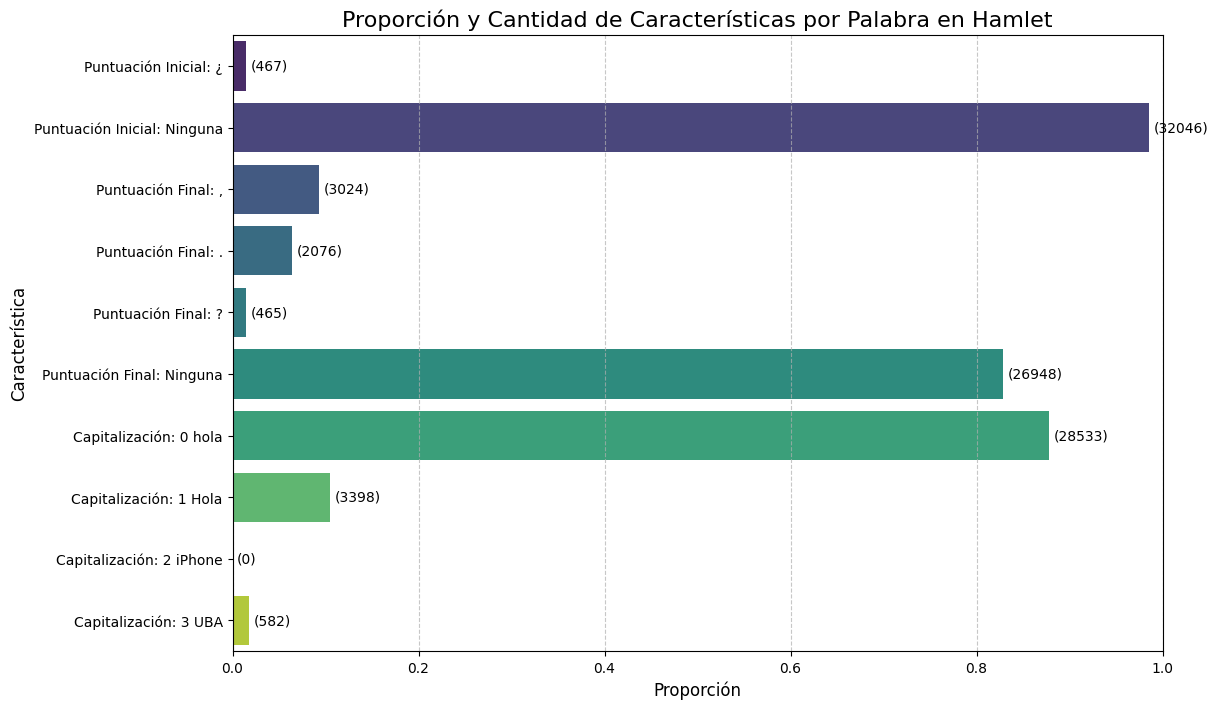

-- Resumen del Análisis por Palabra para Hamlet --
Total de palabras analizadas: 32513
Puntuación Inicial: ¿: 0.0144 (Cantidad: 467)
Puntuación Inicial: Ninguna: 0.9856 (Cantidad: 32046)
Puntuación Final: ,: 0.0930 (Cantidad: 3024)
Puntuación Final: .: 0.0639 (Cantidad: 2076)
Puntuación Final: ?: 0.0143 (Cantidad: 465)
Puntuación Final: Ninguna: 0.8288 (Cantidad: 26948)
Capitalización: 0 hola: 0.8776 (Cantidad: 28533)
Capitalización: 1 Hola: 0.1045 (Cantidad: 3398)
Capitalización: 2 iPhone: 0.0000 (Cantidad: 0)
Capitalización: 3 UBA: 0.0179 (Cantidad: 582)
------------------------------


In [43]:
# Analizar y graficar el DataFrame de Hamlet por palabra
analyze_and_plot_word_features(df_hamlet, 'Hamlet')

#### Dataset La Dama Boba

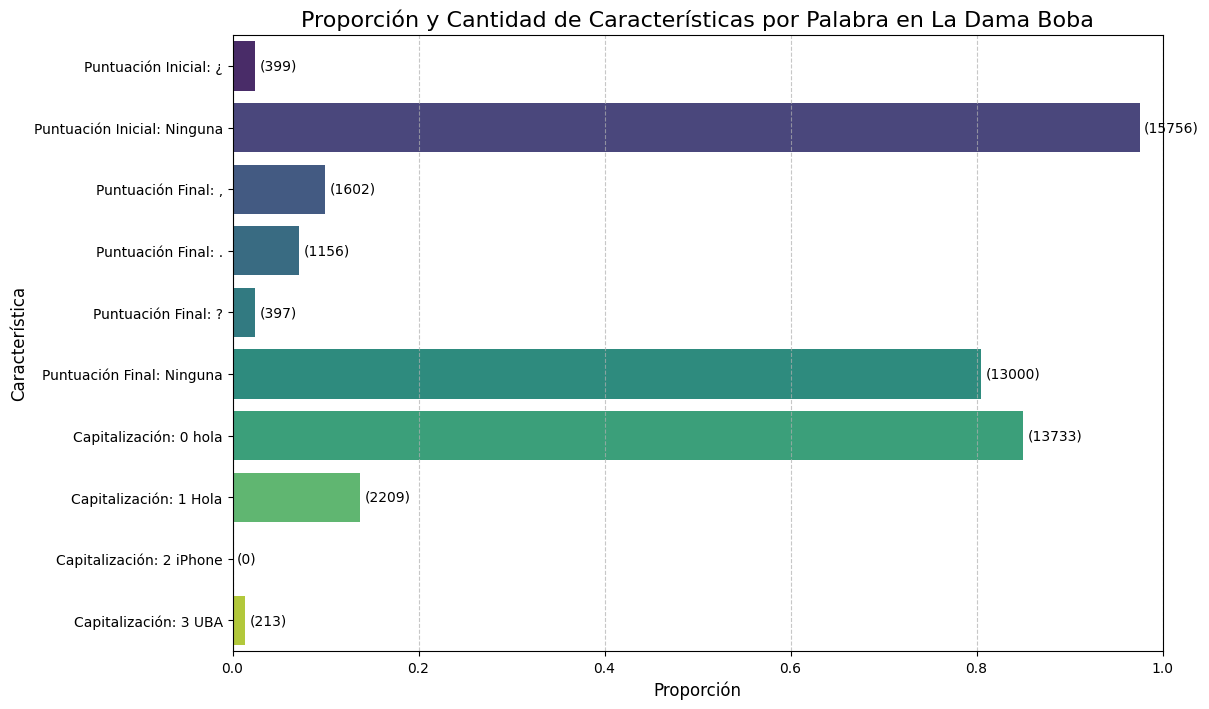

-- Resumen del Análisis por Palabra para La Dama Boba --
Total de palabras analizadas: 16155
Puntuación Inicial: ¿: 0.0247 (Cantidad: 399)
Puntuación Inicial: Ninguna: 0.9753 (Cantidad: 15756)
Puntuación Final: ,: 0.0992 (Cantidad: 1602)
Puntuación Final: .: 0.0716 (Cantidad: 1156)
Puntuación Final: ?: 0.0246 (Cantidad: 397)
Puntuación Final: Ninguna: 0.8047 (Cantidad: 13000)
Capitalización: 0 hola: 0.8501 (Cantidad: 13733)
Capitalización: 1 Hola: 0.1367 (Cantidad: 2209)
Capitalización: 2 iPhone: 0.0000 (Cantidad: 0)
Capitalización: 3 UBA: 0.0132 (Cantidad: 213)
------------------------------


In [44]:
# Analizar y graficar el DataFrame de La Dama Boba por palabra
analyze_and_plot_word_features(df_dama_boba, 'La Dama Boba')

#### Dataset Wikipedia

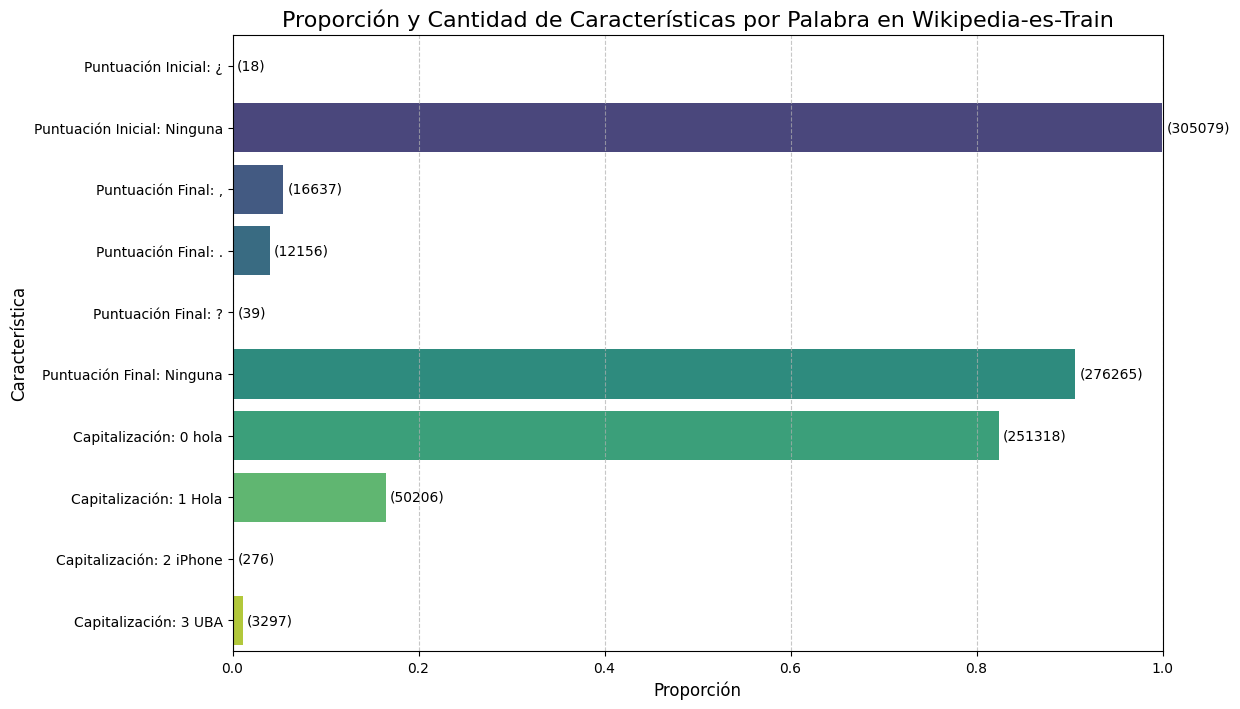

-- Resumen del Análisis por Palabra para Wikipedia-es-Train --
Total de palabras analizadas: 305097
Puntuación Inicial: ¿: 0.0001 (Cantidad: 18)
Puntuación Inicial: Ninguna: 0.9999 (Cantidad: 305079)
Puntuación Final: ,: 0.0545 (Cantidad: 16637)
Puntuación Final: .: 0.0398 (Cantidad: 12156)
Puntuación Final: ?: 0.0001 (Cantidad: 39)
Puntuación Final: Ninguna: 0.9055 (Cantidad: 276265)
Capitalización: 0 hola: 0.8237 (Cantidad: 251318)
Capitalización: 1 Hola: 0.1646 (Cantidad: 50206)
Capitalización: 2 iPhone: 0.0009 (Cantidad: 276)
Capitalización: 3 UBA: 0.0108 (Cantidad: 3297)
------------------------------


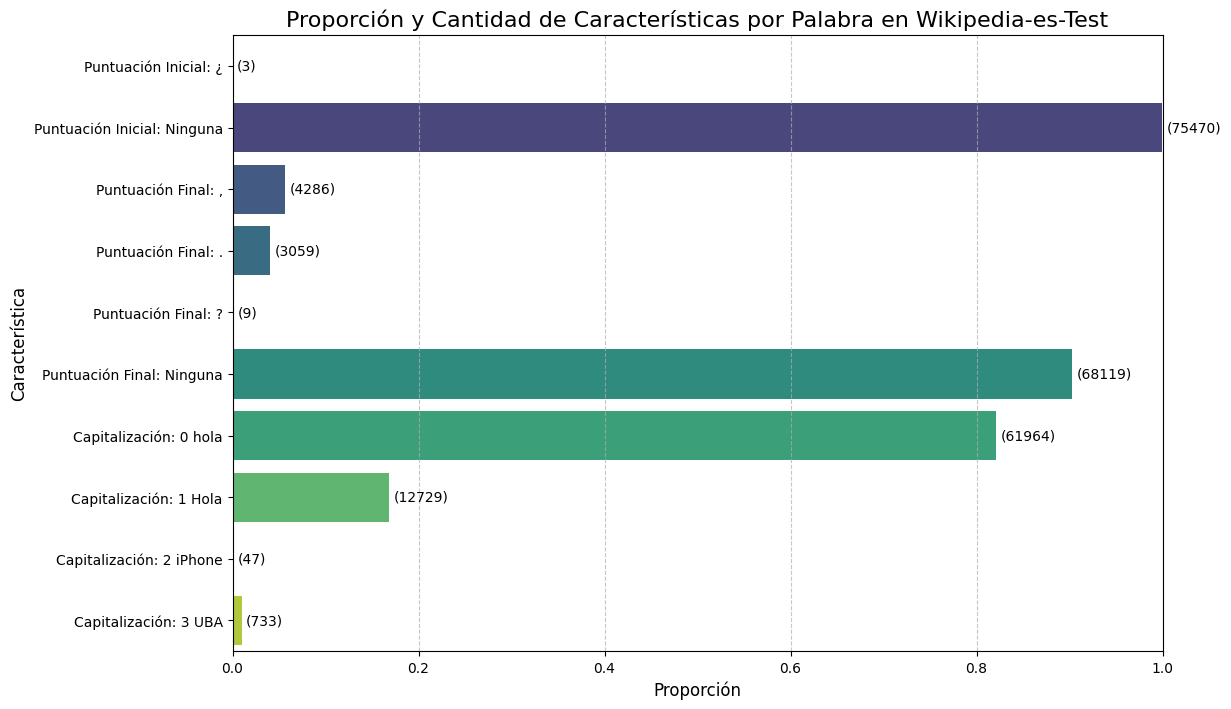

-- Resumen del Análisis por Palabra para Wikipedia-es-Test --
Total de palabras analizadas: 75473
Puntuación Inicial: ¿: 0.0000 (Cantidad: 3)
Puntuación Inicial: Ninguna: 1.0000 (Cantidad: 75470)
Puntuación Final: ,: 0.0568 (Cantidad: 4286)
Puntuación Final: .: 0.0405 (Cantidad: 3059)
Puntuación Final: ?: 0.0001 (Cantidad: 9)
Puntuación Final: Ninguna: 0.9026 (Cantidad: 68119)
Capitalización: 0 hola: 0.8210 (Cantidad: 61964)
Capitalización: 1 Hola: 0.1687 (Cantidad: 12729)
Capitalización: 2 iPhone: 0.0006 (Cantidad: 47)
Capitalización: 3 UBA: 0.0097 (Cantidad: 733)
------------------------------


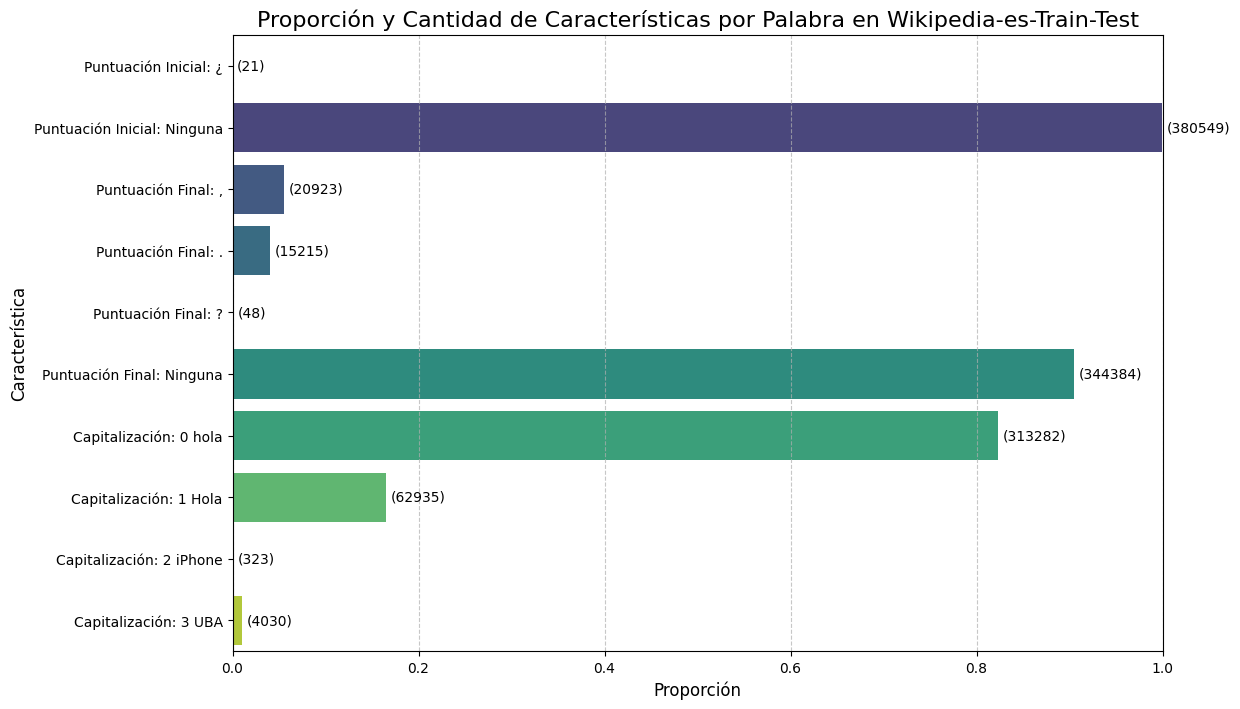

-- Resumen del Análisis por Palabra para Wikipedia-es-Train-Test --
Total de palabras analizadas: 380570
Puntuación Inicial: ¿: 0.0001 (Cantidad: 21)
Puntuación Inicial: Ninguna: 0.9999 (Cantidad: 380549)
Puntuación Final: ,: 0.0550 (Cantidad: 20923)
Puntuación Final: .: 0.0400 (Cantidad: 15215)
Puntuación Final: ?: 0.0001 (Cantidad: 48)
Puntuación Final: Ninguna: 0.9049 (Cantidad: 344384)
Capitalización: 0 hola: 0.8232 (Cantidad: 313282)
Capitalización: 1 Hola: 0.1654 (Cantidad: 62935)
Capitalización: 2 iPhone: 0.0008 (Cantidad: 323)
Capitalización: 3 UBA: 0.0106 (Cantidad: 4030)
------------------------------


In [45]:
# Convertir el split 'train' del dataset ds a un DataFrame
df_wikipedia_train = ds['train'].to_pandas()

# Convertir el split 'test' del dataset ds a un DataFrame
df_wikipedia_test = ds['test'].to_pandas()

# Unir ambos DataFrames
df_wikipedia_combined = pd.concat([df_wikipedia_train, df_wikipedia_test], ignore_index=True)

analyze_and_plot_word_features(df_wikipedia_train, 'Wikipedia-es-Train', text_column='contenido')
analyze_and_plot_word_features(df_wikipedia_test, 'Wikipedia-es-Test', text_column='contenido')
analyze_and_plot_word_features(df_wikipedia_combined, 'Wikipedia-es-Train-Test', text_column='contenido')

### Gráficos por palabra union de todos los datasets

In [48]:
df_hamlet_text = df_hamlet[['sentence']].rename(columns={'sentence': 'text_content'})

df_dama_boba_text = df_dama_boba[['sentence']].rename(columns={'sentence': 'text_content'})

df_wikipedia_combined_text = df_wikipedia_combined[['contenido']].rename(columns={'contenido': 'text_content'})

# Unir todos los DataFrames
df_all_datasets_combined = pd.concat([df_hamlet_text, df_dama_boba_text, df_wikipedia_combined_text], ignore_index=True)


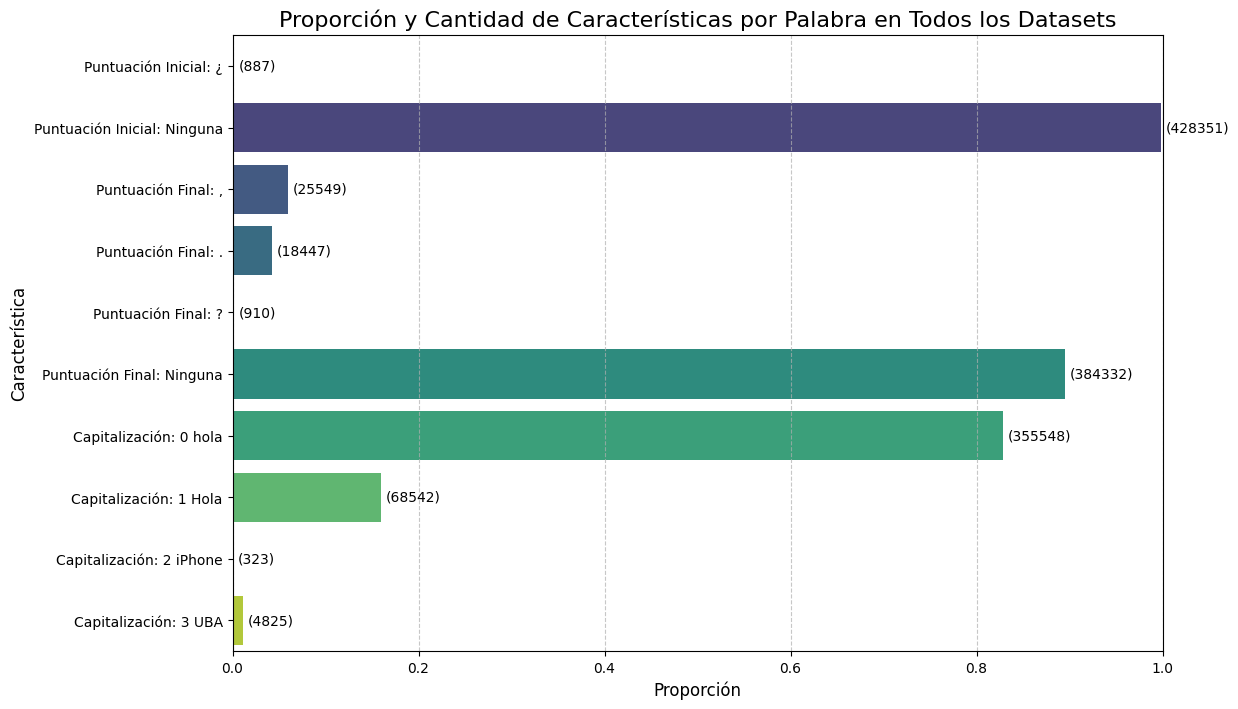

-- Resumen del Análisis por Palabra para Todos los Datasets --
Total de palabras analizadas: 429238
Puntuación Inicial: ¿: 0.0021 (Cantidad: 887)
Puntuación Inicial: Ninguna: 0.9979 (Cantidad: 428351)
Puntuación Final: ,: 0.0595 (Cantidad: 25549)
Puntuación Final: .: 0.0430 (Cantidad: 18447)
Puntuación Final: ?: 0.0021 (Cantidad: 910)
Puntuación Final: Ninguna: 0.8954 (Cantidad: 384332)
Capitalización: 0 hola: 0.8283 (Cantidad: 355548)
Capitalización: 1 Hola: 0.1597 (Cantidad: 68542)
Capitalización: 2 iPhone: 0.0008 (Cantidad: 323)
Capitalización: 3 UBA: 0.0112 (Cantidad: 4825)
------------------------------


In [49]:
# Analizar y graficar el DataFrame combinado de todos los datasets por palabra
analyze_and_plot_word_features(df_all_datasets_combined, 'Todos los Datasets', text_column='text_content')